# Script to Extract Data
**Input Data:** Original Data  
**Output Data:** Data for a specific variable and spatial extent  
**Description:** Extracts data for a specific variable and spatial extent and exports them to a new file.  
**Date:** June 2022  
**Author:** Emma Perkins  

In [1]:
# import relevant packages
import xarray as xr
import glob
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import spatial

### Load Full Data

In [2]:
# full data
path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/daily/aice_d/'  # change to your paths
file1 = path+'b.e11.B1850C5CN.f09_g16.005.cice.h1.aice_d_nh.19000101-19991231.nc'  # change to your files
file2 = path+'b.e11.B1850C5CN.f09_g16.005.cice.h1.aice_d_nh.20000101-20991231.nc'
files = [file1, file2]
full_data = xr.open_mfdataset(files, concat_dim=None)

### Select Variable of Interest

In [3]:
data_var = 'aice_d'  # change to variable of interest from climate model data
data_select = full_data[data_var]

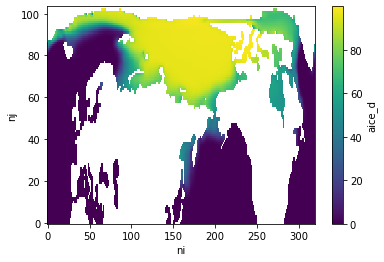

In [4]:
data_select.mean(dim='time').plot()

### Convert from POP grid to Lat/Lon

In [5]:
data_select = data_select.rename({'TLON': 'lon', 'TLAT': 'lat'})

In [6]:
print(data_select)

<xarray.DataArray 'aice_d' (time: 73000, nj: 104, ni: 320)>
dask.array<concatenate, shape=(73000, 104, 320), dtype=float32, chunksize=(36500, 104, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-02 00:00:00 ... 2100-01-01 00:00:00
    lon      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    lat      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          %
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    comment:        none
    cell_methods:   time: mean
    time_rep:       averaged


In [41]:
float(data_select.isel(ni=100).isel(nj=40).lat)

nan

In [5]:
float(data_select.lon[0][0])

320.55792236328125

In [62]:
def find_nearest(array, value):
    idx = np.where(np.abs(array - value) == (np.abs(array - value)).min())
    return idx


find_nearest(data_select.lon, 320)

(array([91]), array([0]))

In [48]:
%%time

latlon = np.zeros([33280, 2])
idx = 0
for j in range(0, len(data_select.nj)):
    for i in range(0, len(data_select.ni)):
        latlon_point = [float(data_select.lat[j, i]), float(data_select.lon[j, i])]
        # latlon.append(latlon_point)
        latlon[idx] = latlon_point
        idx = idx + 1

CPU times: user 2min 40s, sys: 1.93 s, total: 2min 42s
Wall time: 2min 53s


In [51]:
id = np.where((latlon[:, 0]>=0))

In [53]:
latlon = latlon[id]

In [ ]:
%%time

new_data = np.zeros([len(latlon), 3])
for i in range(0, len(latlon)):
    data_index = np.where(np.logical_and(data_select.mean(dim='time').lat == latlon[i,0], data_select.mean(dim='time').lon == latlon[i,1]))
    data_point = float(data_select.mean(dim='time').isel(nj=data_index[0][0]).isel(ni=data_index[1][0]))
    new_data[i] = [latlon[i, 0], latlon[i, 1], data_point]

In [54]:
print(latlon)

[[ 30.37925911 320.55792236]
 [ 30.38017273 321.67376709]
 [ 30.38199806 322.78964233]
 ...
 [ 72.97351074 310.87799072]
 [ 72.90960693 311.23446655]
 [ 72.84783936 311.59719849]]


In [59]:
data_select.lat

<xarray.DataArray 'lat' (nj: 104, ni: 320)>
dask.array<where, shape=(104, 320), dtype=float32, chunksize=(104, 320), chunktype=numpy.ndarray>
Coordinates:
    lon      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    lat      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  T grid center latitude
    units:      degrees_north
    bounds:     latt_bounds

In [65]:
index = np.where(np.logical_and(data_select.mean(dim='time').lat == latlon[3,0], data_select.mean(dim='time').lon == latlon[3,1]))

In [77]:
index[1][0]

3

In [78]:
float(data_select.mean(dim='time').isel(nj=index[0][0]).isel(ni=index[1][0]))

0.0

In [72]:
latlon[3]

array([ 30.38473511, 323.90548706])

In [42]:
test_point = [80, 80]

In [43]:
distance, index = spatial.KDTree(latlon).query(test_point)

In [44]:
print(distance)
print(index)

0.9475614319981639
24449


In [45]:
latlon[index]

array([80.87691498, 80.35901642])

In [35]:
ids = np.where(np.logical_and(latlon[:,0] > 43, latlon[:,0] < 47))

In [36]:
latlon[ids]

array([[ 43.00987625, 123.33024597],
       [ 43.0283699 , 124.47899628],
       [ 43.04557419, 125.62792969],
       ...,
       [ 46.94944   , 317.31945801],
       [ 46.94430161, 318.39169312],
       [ 46.94173431, 319.46389771]])

In [66]:
target_grid = xe.util.grid_2d(-180, 180, 1, 0, 90, 0.5)

In [67]:
#create map
regridder = xe.Regridder(data_select, target_grid, 'nearest_s2d', periodic=True, reuse_weights=False)

#perform regridding
data_select = regridder(data_select)

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/array/core.py:450: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [9]:
data_avg = data_select.mean(dim='time')

In [10]:
print(data_avg)

<xarray.DataArray (y: 180, x: 360)>
dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 0.25 0.25 0.25 0.25 0.25 ... 89.75 89.75 89.75 89.75
Dimensions without coordinates: y, x


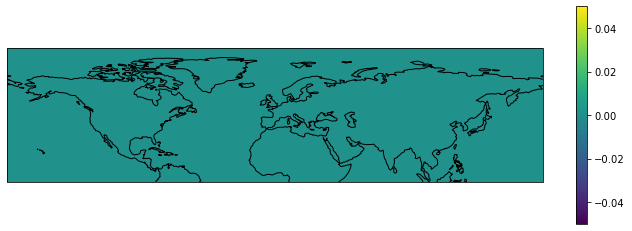

In [11]:
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
data_avg.plot.pcolormesh(ax=ax, x="lon", y="lat")
ax.coastlines()

In [ ]:
float(data_avg.isel(y=179).isel(x=50))

### Select Area of Interest

In [12]:
# determine variable names
lat_var = 'lat'  # name of latitude variable for original data
lon_var = 'lon'  # name of longitude variable for original data

# rename lat lon variables to all be lat lon
data_select = data_select.rename({lat_var: 'lat', lon_var: 'lon'})

# sort by latitude:
data_select = data_select.sortby('lat')

lon_type = 'long3'  # longitude coordinate type: long1 (-180 - 180) or long 3 (0 - 360)
if lon_type == 'long3':
    lon_new = (data_select.lon + 180) % 360 - 180
    data_select['lon'] = lon_new
data_select = data_select.sortby('lon')

# select input area from left to right / west to east:
lat_min = 50  # minimum latitude
lat_max = 90  # maximum latitude
lon_min = 0  # minimum longitude
lon_max = 40  # maximum longitude

if lon_min < lon_max:
    data_select = data_select.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
else:
    data_select1 = data_select.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, 180))
    data_select2 = data_select.sel(lat=slice(lat_min, lat_max), lon=slice(-180, lon_max))
    data_select = xr.concat([data_select1, data_select2], dim='lon')
data_select = data_select.sortby('lon')

In [13]:
data_select = data_select.isel(lon=np.arange(1, len(data_select.lon - 1)))

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [14]:
data_select_avg = data_select.mean(dim='time')

### Standardize Time Step
Can skip if already using the desired time step.

In [11]:
%%time

analysis_time_type = '1D'  # time step for analysis (ex: 6H, 1D, 1M, 1Y, etc.)
data_select = data_select.resample(time=analysis_time_type).mean('time')  # choose either sum.() or mean.() for accumulation or instantaneous variables respectively

IOStream.flush timed out


CPU times: user 1min 42s, sys: 1.67 s, total: 1min 44s
Wall time: 1min 42s


### Export Data - Long Step (6+ Hours, Run Overnight)

In [12]:
%%time

outpath = '/glade/campaign/cgd/ppc/eperkins/cesm/'  # path for new observational data file
data_name = 'cesmLE_B1850C5CN.005_hs_d_1900_2099_1D_EArctic'  # name for new data file

data_select.load().to_netcdf(outpath+data_name+'.nc')

CPU times: user 2min 9s, sys: 5min 39s, total: 7min 49s
Wall time: 10min 19s
